In [78]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

In [79]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [80]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.samples,inplace=True)
data_rel.set_index(target.samples,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

In [81]:
'''Filtering based on productivity samples, not needed for first part of analysis'''
#retain only productivity samples 
#productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90)
#productivity = productivity[productivity.tot_bacprod < 90]

#idx_prod = productivity.samples.values
#display(idx_prod)
#prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
#prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
#prod_rel_error = prod_error/prod

'Filtering based on productivity samples, not needed for first part of analysis'

In [82]:
'''Parameter abun for initial filtering of OTUs'''
abundances = np.arange(0.0001,0.1001,0.0005)
n_otus = np.zeros(len(abundances))
r2_cv = np.zeros(len(abundances))

In [83]:
from analysis_functions import preprocess_df
t=0
cv=5
for abun in abundances: 
    data_abs = preprocess_df(data_abs,abun,True)
    otus = list(data_abs.columns)
    n_otus[t] = len(otus)
    lassoCV = get_lassoCV(5)
    lassoCV.fit(data_abs[otus],hna)
    alpha = lassoCV.alpha_
    lasso = Lasso(alpha,max_iter=20000,normalize=True)
    pred_cv_final = cross_val_predict(lasso, data_abs[otus], hna, cv=cv)
    r2_cv[t] = get_r2(pred_cv_final, hna)
    t+=1    

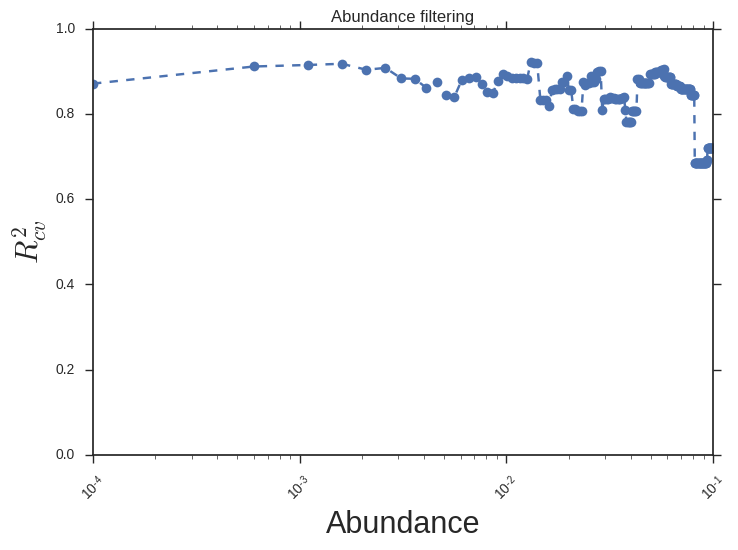

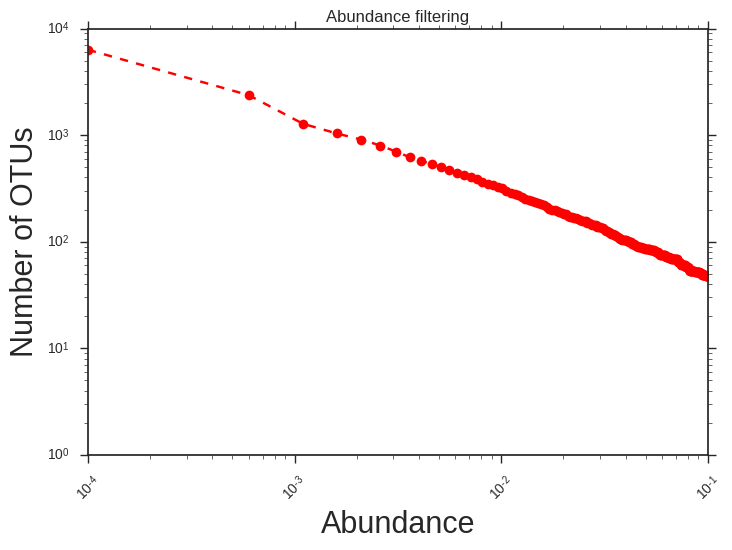

In [86]:
plt.figure()
plt.axis([0.0001,0.1,0,1])
plt.plot(abundances,r2_cv,'o--')#, scatter_kws={"s": 0.7})
plt.xlabel('Abundance', size=22)
plt.xticks(rotation=45,size=10)
plt.xscale('log')
plt.ylabel(r'$R^2_{cv}$', size=22)
plt.yticks(size=10)
plt.title('Abundance filtering')
plt.show()

plt.figure()
plt.axis([0.0001,0.1,1,10000])
plt.plot(abundances,n_otus,'ro--')#, scatter_kws={"s": 0.7})
plt.xlabel('Abundance', size=22)
plt.xticks(rotation=45,size=10)
plt.ylabel('Number of OTUs', size=22)
plt.xscale('log')
plt.yscale('log')
plt.yticks(size=10)
plt.title('Abundance filtering')
plt.show()

Let's apply the preprocessing in function of the productivity samples: 

In [89]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [90]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.samples,inplace=True)
data_rel.set_index(target.samples,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

**Preprocessing: ** First filter productivity outliers (productivity > 90). 

In [91]:
#retain only productivity samples 
productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90)
productivity = productivity[productivity.tot_bacprod < 90]

idx_prod = productivity.samples.values
#display(idx_prod)
prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
#prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
#prod_rel_error = prod_error/prod

We can now use the same script as above: 

In [92]:
n_otus_prod = np.zeros(len(abundances))
r2_cv_prod = np.zeros(len(abundances))

In [93]:
t=0
for abun in abundances: 
    data_abs_prod = data_abs.loc[idx_prod,:] 
    data_abs_prod = preprocess_df(data_abs_prod,abun,True)
    otus_prod = list(data_abs_prod.columns)
    n_otus[t] = len(otus_prod)
    lassoCV = get_lassoCV(5)
    lassoCV.fit(data_abs[otus_prod],hna)
    alpha = lassoCV.alpha_
    lasso = Lasso(alpha,max_iter=20000,normalize=True)
    pred_cv_final = cross_val_predict(lasso, data_abs[otus_prod], hna, cv=cv)
    r2_cv[t] = get_r2(pred_cv_final, hna)
    t+=1  

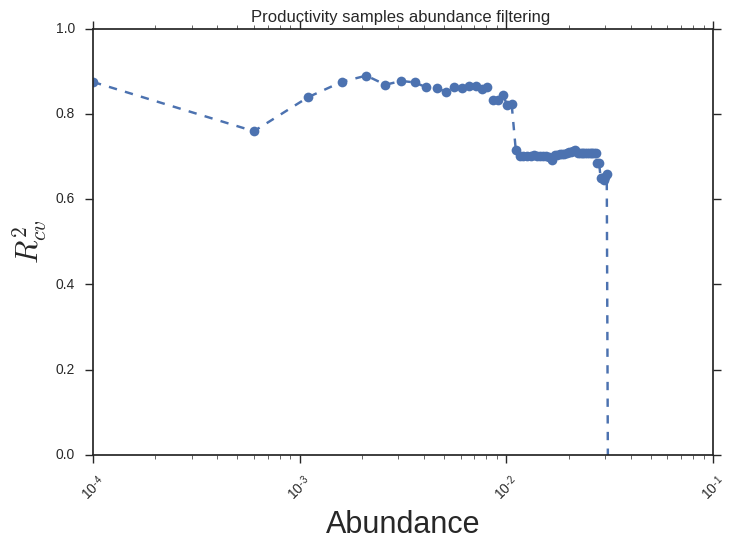

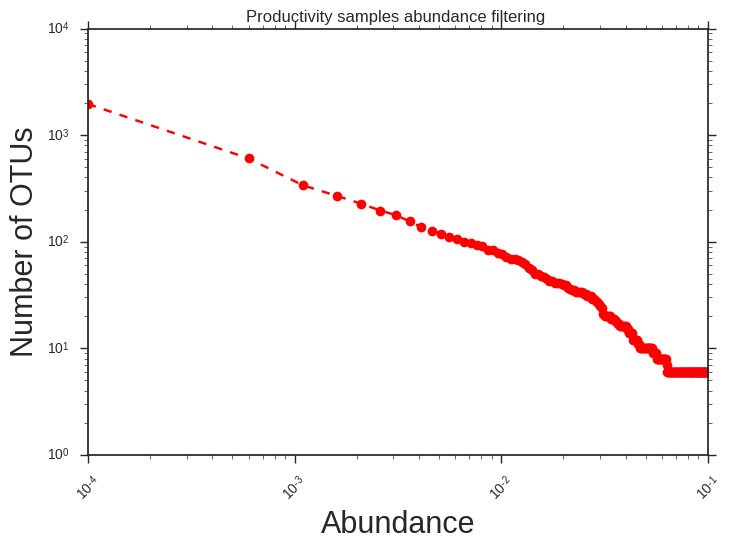

In [94]:
plt.figure()
plt.axis([0.0001,0.1,0,1])
plt.plot(abundances,r2_cv,'o--')#, scatter_kws={"s": 0.7})
plt.xlabel('Abundance', size=22)
plt.xticks(rotation=45,size=10)
plt.xscale('log')
plt.ylabel(r'$R^2_{cv}$', size=22)
plt.yticks(size=10)
plt.title('Productivity samples abundance filtering ')
plt.show()

plt.figure()
plt.axis([0.0001,0.1,1,10000])
plt.plot(abundances,n_otus,'ro--')#, scatter_kws={"s": 0.7})
plt.xlabel('Abundance', size=22)
plt.xticks(rotation=45,size=10)
plt.ylabel('Number of OTUs', size=22)
plt.xscale('log')
plt.yscale('log')
plt.yticks(size=10)
plt.title('Productivity samples abundance filtering ')
plt.show()

**Conclusion: **
- The two 'optimal' thresholds vary considerably depending on the kind of filtering;   
- Either we choose a low threshold to make sure not to exclude OTU's which might contribute; 
- We implement an initial abundance selection method at the start of the pipeline; 